# Cough classifier
This notebook trains and tests a binary classifier identifying whether there is a cough in an audio file or not. The data comes from the Embeded Systems Lab at EPFL and thus is private. The data originates from 16 subjects whose audio signals were recorded by a device designed at EPFL.

The cough classifier is a neural network based on CNN. The chosen preprocessing of the audio signals is STFT. Due to the low amount of data, data augmentation is crucial. Therefore, more data is produced doing time shifting and splitting each audio file into sounds of 0.7 seconds. This window length was abritarily chosen. It, however, effects the performance of the model, thus one can do a subsequent study on finding the optimal window length.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchaudio
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install prettytable

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os

import IPython.display as ipd
from enum import Enum
sys.path.append(os.path.abspath('../src'))
from helpers import *
from dataset_gen import *
import pickle
from prettytable import PrettyTable

You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\sidla\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Hyperparameters and Variables

In [2]:
# STFT parameters
fs = 16000 #sampling frequency
n_fft = 256 #size of stft former: 256
H = int(n_fft/2) # Hop length (number of bins between windows)

train_ratio = 0.8 # percentage of total dataset attributed to train
# 1-train_ratio = test_ratio

# Training Hyperparameters
batch_size = 64 # should be 32 for better training
num_epochs = 3 # should be increased to 20, but local RAM cannot cope with many
learning_rate = 0.001

# Load data into pytorch dataloader seperated into train and test

In [3]:
# Folder where the train data is (now on local google machine)
data_folder = './train/train/'
subj_ids = os.listdir(data_folder)
print("There are {0} subjects".format(len(subj_ids)))
seed = 1
np.random.seed(seed)

There are 16 subjects


In [4]:
import torch
import torchaudio
from torchaudio import transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import random

class CoughDataset(Dataset): # inherits Dataset
  def __init__(self, subj_ids):
    # Data loading
    self.raw_audio = torch.zeros(0)
    self.raw_imu_data = torch.zeros(0)
    self.labels = torch.zeros(0)
    for ind, subj_id in enumerate(subj_ids):
        audio_data_subj, imu_data_subj, labels_subj, total_coughs_subj = get_samples_for_subject(data_folder, subj_id, 0.7, 2)
        self.raw_audio = torch.cat((self.raw_audio, torch.tensor(audio_data_subj)), 0) # Shape (N, n_freq_samples, n_chan)
        self.raw_imu_data = torch.cat((self.raw_imu_data, torch.tensor(imu_data_subj)), 0)
        self.labels = torch.cat((self.labels, torch.tensor(labels_subj)), 0)
    self.raw_audio = torch.permute(self.raw_audio, (0,2,1)) # Shape (N, n_chan, n_freq_samples)


  def __getitem__(self,idx):
    # called when you do dataset[i]
    num_chan = self.raw_audio.shape[1] # Number of audio channels (2 as 2 microphones)
    L = self.raw_audio.shape[2] # Number of frequency samples (This is the same for every data)

    # (num_chan,   M = int(n_fft/2)+1,  Mf = int(L/H)+1)
    stft_tensor = torch.zeros(num_chan, int(n_fft/2)+1, int(L/H)+1, dtype=torch.cdouble) # (num_chan, M, Mf)
    for i in range(num_chan):
      stft_tensor[i] = torch.stft(self.raw_audio[idx,i,:], n_fft, hop_length=H, win_length=n_fft, window=None, 
              center=True, pad_mode='reflect', normalized=False, onesided=None,
              return_complex=True)
      
    # using pytorch's amplitude to db 
    #top_db is minimum negative cut-off in decibels. A reasonable number is 80
    stft_tensordb = transforms.AmplitudeToDB(top_db=80)(abs(stft_tensor))
    #print("STFT_tensor shape outputed of get_item:",stft_tensor.shape)

    return stft_tensordb, self.labels[idx] #TODO no imu implemented yet

  def __len__(self):
    # called when you do len(dataset)
    return self.labels.shape[0]

c:\Users\sidla\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Random split of train_ratio:(1-train_ratio) between training and testing
# Keeping in mind the limitation of a patient must not be in train and test set at the same time
num_subj = len(subj_ids)
n_train = int(num_subj*train_ratio)
print("Number of train subjects:", n_train)
print("Number of test subjects:", num_subj - n_train)

# shuffle list of patients to not use the same for train/test split everytime
random.shuffle(subj_ids)
print("List of subjects:", subj_ids[0:n_train])

Number of train subjects: 12
Number of test subjects: 4
List of subjects: ['20794', '49661', '97706', '55502', '74768', '14342', '84479', '87447', '49179', '87369', '14547', '38936']


# Training

In [6]:
# Initialize pytorch train Dataset
train_ds = CoughDataset(subj_ids[0:n_train])

# Create training data loader iterator
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [7]:
# Checking the correct shape of the batched data
diter = iter(train_dl)
ddata = next(diter)
features, labss = ddata
print(features.shape, labss.shape)

torch.Size([64, 2, 129, 88]) torch.Size([64])


In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("DEVICE IS : ", device)

################################################################################
# Cough Classification Model (CNN test)
################################################################################
# convnet setup for n_fft = 256 and hop_size = int(n_fft/2) Dimensions change with these
class ConvNet(nn.Module):
    def __init__(self): # shows all the layers
        super().__init__()
        self.conv1 = nn.Conv2d(2,8,5) # 2 channels as 2 microphones
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8,16,5)
        self.conv3 = nn.Conv2d(16,32,5)
        self.fc1 = nn.Linear(12000, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        # initial size: 16, 2, 129, 88 (relu are activation functions)
        x = F.relu(self.conv1(x))   
        x = self.pool(x)            
        x = F.relu(self.conv2(x))   
        x = self.pool(x)           
        x = F.relu(self.conv3(x))   

        #flatten for input to linear layer
        #print(x.shape)
        x = torch.flatten(x, 1)    
        #print(x.shape)
        x = F.relu(self.fc1(x))    
        x = self.fc2(x)             
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss() #softmax already included in the crossentropyloss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # could try other optimizers maybe

n_total_steps = len(train_dl)
for epoch in range(num_epochs):

    running_loss = 0.0

    for i, (spectrograms, labels) in enumerate(train_dl):
        spectrograms = (spectrograms.float()).to(device)
        labels = labels.long().to(device)

        # Forward pass
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        # Backward and optimizer
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}') #will give us avg loss for this epoch

print('Finished Training')
PATH = './cnn.pth' #pth common file ending for pytorch models
torch.save(model.state_dict(), PATH) #save the model state_dict will save the parameters of the model

DEVICE IS :  cpu
[1] loss: 0.257
[2] loss: 0.143
[3] loss: 0.111
Finished Training


# Testing

In [9]:
# # Initialize pytorch train Dataset
test_ds = CoughDataset(subj_ids[n_train:num_subj])

# # Create test data loader iterator
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [10]:
################################################################################
# Testing our CNN model
################################################################################
from sklearn import metrics
loaded_model = ConvNet() #since we only saved the params, need to load a new model
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device) #to use GPU
loaded_model.eval() # set some internal config so they are better for evaluation (FOR TESTING)

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_dl.dataset)
    probs = torch.zeros(n_samples)
    truths = torch.zeros(n_samples)
    accum = 0

    for spectrograms, labels in test_dl:
        spectrograms = spectrograms.float().to(device)
        labels = labels.long().to(device)
        outputs = model(spectrograms)

        # Correct predictions (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        # Probabilities for Area Under the ROC Curve
        preds = nn.Softmax(dim=1)(outputs)[:, 1]
        probs[accum:accum+len(labels)] = preds
        truths[accum:accum+len(labels)] = labels

        accum+=len(labels)

    # Accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    # AUC Score
    auc_score = metrics.roc_auc_score(truths, probs)*100
    print(f'AUC Score: {auc_score} %')

Accuracy of the model: 91.69073916737469 %
AUC Score: 92.9022230459335 %


In [11]:
# Get the number of parameters
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

# print paramter size per layer and total parameter amount
count_parameters(model)
print("Total parameter amount: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    400     |
|  conv1.bias  |     8      |
| conv2.weight |    3200    |
|  conv2.bias  |     16     |
| conv3.weight |   12800    |
|  conv3.bias  |     32     |
|  fc1.weight  |   768000   |
|   fc1.bias   |     64     |
|  fc2.weight  |    128     |
|   fc2.bias   |     2      |
+--------------+------------+
Total Trainable Params: 784650
Total parameter amount:  784650


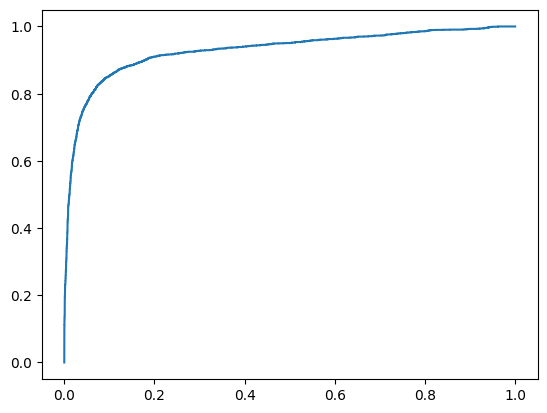

In [12]:
# Plotting the AUC
fpr, tpr, thresholds = metrics.roc_curve(truths, probs)
plt.plot(fpr,tpr)
plt.show()